In [79]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
# import sys
# np.set_printoptions(threshold=sys.maxsize)

In [80]:
c = np.load('data/casper/calib.npy', allow_pickle=True).item()
K0,d0,K1,d1,R,t = c['K0'], c['d0'], c['K1'], c['d1'], c['R'], c['t']

In [81]:
# 13.1 using checker board? by standard calibration

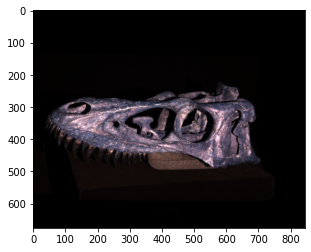

In [82]:
# 13.2
im0 = cv2.imread("data/casper/sequence/frames0_0.png")
size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'],
c['d1'], size, c['R'], c['t'], flags=0)
R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)
rect_img = cv2.remap(im0, *maps0, cv2.INTER_LINEAR)
plt.imshow(rect_img)

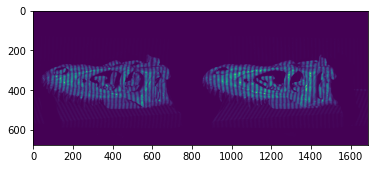

In [83]:
ims0_paths = [x for x in glob.glob('data/casper/sequence/frames0*.png')]
ims0_paths.sort(key=lambda s: int(s.split('.')[0][-2:].strip('_')))
ims1_paths = [x for x in glob.glob('data/casper/sequence/frames1*.png')]
ims1_paths.sort(key=lambda s: int(s.split('.')[0][-2:].strip('_')))
ims0 = []
ims1 = []
for (im1,im2) in zip(ims0_paths,ims1_paths):
    image = cv2.imread(im1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float64)
    image = cv2.remap(image, *maps0, cv2.INTER_LINEAR)
    ims0.append(image)
    image = cv2.imread(im2)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float64)
    image = cv2.remap(image, *maps1, cv2.INTER_LINEAR)
    ims1.append(image)
plt.imshow(np.hstack((ims0[2], ims1[2])))

In [84]:
ims1_paths[:5]

['data/casper/sequence\\frames1_0.png',
 'data/casper/sequence\\frames1_1.png',
 'data/casper/sequence\\frames1_2.png',
 'data/casper/sequence\\frames1_3.png',
 'data/casper/sequence\\frames1_4.png']

6.283185307179586 0.0 -6.264181636136385 6.280851018194252
6.283185307179586 0.0 -6.281619014914443 6.277598039571682


(<matplotlib.image.AxesImage at 0x1b2000d85b0>,
 <Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1b2001119a0>)

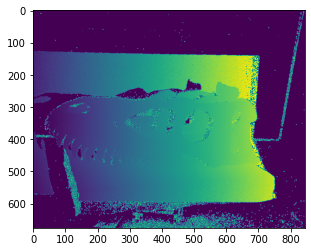

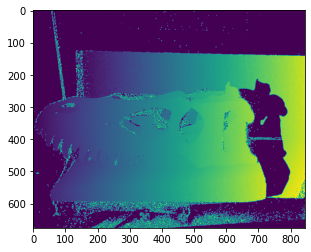

In [85]:
def unwrap(ims):
    primary = ims[2:18]
    secondary = ims[18:]
    fft_primary =  np.fft.rfft(primary, axis=0)
    theta_primary = np.angle(fft_primary[1])
    fft_secondary = np.fft.rfft(secondary, axis=0)
    theta_secondary = np.angle(fft_secondary[1])
    theta_c = np.mod(theta_secondary - theta_primary, 2*np.pi)
    print(theta_c.max(), theta_c.min(), (theta_secondary - theta_primary).min(), (theta_secondary - theta_primary).max())
    n1 = 40 # given in the description
    o_primary = np.round((n1 * theta_c - theta_primary) / (2*np.pi))
    theta = np.mod((2*np.pi*o_primary + theta_primary) / n1, 2*np.pi)
    return theta
plt.imshow(unwrap(ims0)), plt.figure(2), plt.imshow(unwrap(ims1))

((676, 844), 108729, 570544, 538929)

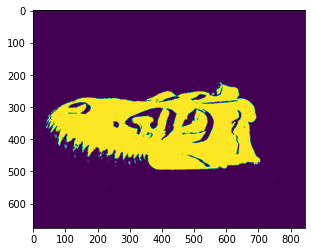

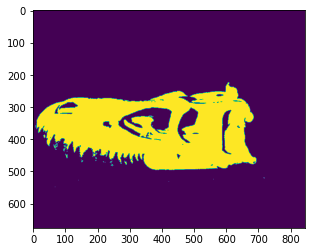

In [86]:
mask0 = ims0[0] - ims0[1] > 20
mask1 = ims1[0] - ims1[1] > 20
plt.imshow(mask0)
plt.figure(2)
plt.imshow(mask1)
mask0.shape,mask0.sum(),mask0.shape[0]*mask0.shape[1], (mask0==mask1).sum()

6.283185307179586 0.0 -6.264181636136385 6.280851018194252
6.283185307179586 0.0 -6.281619014914443 6.277598039571682


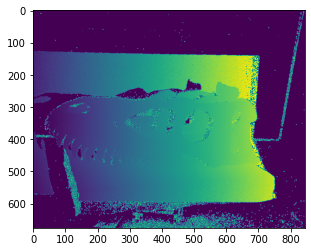

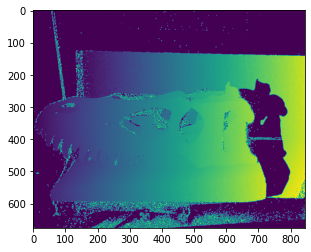

In [87]:
theta0 = unwrap(ims0)
theta1 = unwrap(ims1)
plt.imshow(theta0)
plt.figure(2)
plt.imshow(theta1)

In [125]:
deltas = []
matches0 = []
matches1 = []
disparity = np.zeros(mask0.shape).astype(np.int32)
for i0 in range(mask0.shape[0]):
    for j0 in range(mask0.shape[1]):
        if not mask0[i0,j0]:
            continue
        angle = theta0[i0,j0]
        minn = np.inf
        jcorr = -1
        for j1 in range(mask1.shape[1]):
            if not mask1[i0,j1]:
                continue
            if abs(angle-theta1[i0,j1]) < minn:
                jcorr = j1
                minn = abs(angle-theta1[i0,j1])
        if jcorr != -1 and minn != np.inf and minn < .1:
            disparity[i0,j0] = jcorr-j0
            matches0.append([j0,i0])
            matches1.append([j1,i0])

(<matplotlib.image.AxesImage at 0x1b20ee273d0>, 572.0)

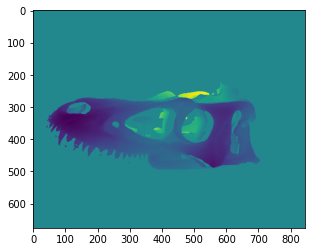

In [126]:
plt.imshow(cv2.medianBlur(disparity.astype(np.float32), 5)), disparity.astype(np.float32).max()

In [183]:
matches0 = np.array(matches0).astype(np.float32).T
matches1 = np.array(matches1).astype(np.float32).T
triang = cv2.triangulatePoints(P0,P1,matches1,matches0)
Q = triang / triang[3]

In [186]:
matches0[:,:10], matches1[:,:10], Q[:,:10]

(array([[575., 580., 581., 580., 581., 582., 583., 574., 580., 581.],
        [224., 224., 224., 225., 225., 225., 225., 226., 226., 226.]],
       dtype=float32),
 array([[843., 843., 843., 843., 843., 843., 843., 843., 843., 843.],
        [224., 224., 224., 225., 225., 225., 225., 226., 226., 226.]],
       dtype=float32),
 array([[356.7136  , 358.96954 , 359.4242  , 358.96957 , 359.4242  ,
         359.87997 , 360.33688 , 356.2658  , 358.9695  , 359.42416 ],
        [-56.796253, -57.155453, -57.227837, -56.62907 , -56.70079 ,
         -56.77269 , -56.84477 , -55.68012 , -56.10268 , -56.173733],
        [571.49677 , 575.1111  , 575.8395  , 575.1111  , 575.8394  ,
         576.56964 , 577.3017  , 570.77936 , 575.1111  , 575.8395  ],
        [  1.      ,   1.      ,   1.      ,   1.      ,   1.      ,
           1.      ,   1.      ,   1.      ,   1.      ,   1.      ]],
       dtype=float32))

In [188]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Q[:3].T)
o3d.visualization.draw_geometries([pcd])